In [51]:
!pip install -r requirements.txt

In [2]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import math
import json

In [3]:
df_responses = pd.read_csv("haaleandja/data_kandidaatide_vastused.csv")

In [56]:
party_to_short = {
    "Reformierakond": "REF",
    "SDE": "SDE",
    "EKRE": "EKRE",
    "Keskerakond": "KE",
    "Parempoolsed": "PAR",
    "Isamaa": "I",
    "Rohelised": "ROH",
    "Eesti 200": "E200",
    "Eestimaa Ühendatud Vasakpartei": "VAS",
    "Üksikkandidaat": "ÜKS"
}
party_to_color = {
    "REF": "yellow",
    "SDE": "red",
    "EKRE": "black",
    "KE": "green",
    "PAR": "darkorange",
    "I": "blue",
    "ROH": "lime",
    "E200": "aqua",
    "VAS": "darkred",
    "ÜKS": "gray"
}
df_responses["party_short"] = df_responses.party.map(party_to_short)
df_responses["color"] = df_responses.party_short.map(party_to_color)

In [57]:
n_to_label = pd.read_csv("haaleandja/kysimused.csv").set_index("id").to_dict()

In [58]:
# Q_{n} label in df_responses is n_to_label[n]

In [59]:
qcols = [c for c in df_responses.columns if "Q_" in c]

In [60]:
df_responses[qcols]

,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Q_9,Q_10,...,Q_20,Q_21,Q_22,Q_23,Q_24,Q_25,Q_26,Q_27,Q_28,Q_29
0,2.0,4.0,2.0,3.0,NaN,3.0,1.0,NaN,1.0,4.0,...,4.0,1.0,1.0,1.0,2.0,4.0,1.0,4.0,4.0,4.0
1,2.0,1.0,3.0,3.0,2.0,3.0,3.0,NaN,2.0,4.0,...,3.0,NaN,1.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0
2,2.0,1.0,1.0,4.0,3.0,4.0,3.0,3.0,2.0,3.0,...,3.0,3.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0,2.0
3,2.0,1.0,1.0,3.0,3.0,3.0,4.0,2.0,2.0,3.0,...,3.0,3.0,1.0,2.0,2.0,3.0,4.0,2.0,4.0,2.0
4,2.0,1.0,1.0,4.0,1.0,2.0,3.0,2.0,1.0,3.0,...,3.0,1.0,1.0,2.0,4.0,4.0,3.0,3.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,1.0,1.0,1.0,3.0,1.0,4.0,1.0,4.0,2.0,4.0,...,4.0,3.0,1.0,2.0,4.0,4.0,3.0,3.0,4.0,3.0
612,2.0,1.0,4.0,4.0,4.0,3.0,4.0,1.0,3.0,1.0,...,2.0,2.0,1.0,2.0,3.0,1.0,4.0,4.0,1.0,2.0
613,3.0,1.0,1.0,3.0,2.0,3.0,1.0,4.0,1.0,4.0,...,3.0,2.0,1.0,2.0,2.0,4.0,4.0,3.0,4.0,3.0
614,3.0,2.0,4.0,3.0,4.0,3.0,3.0,1.0,2.0,3.0,...,2.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0


## PCA on responders

In [78]:
mean_value = df_responses[qcols].mean().mean()

In [85]:
X = df_responses[qcols].fillna(value=mean_value)
y = df_responses["color"]
labels = df_responses["party"]

In [108]:
partyToSubdf = {k: df for k, df in df_responses.groupby("party_short")}

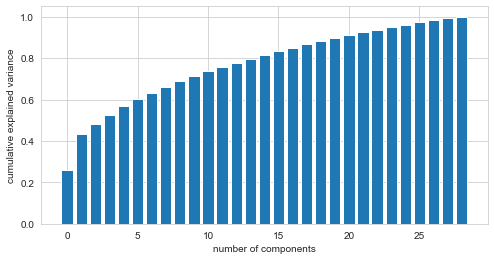

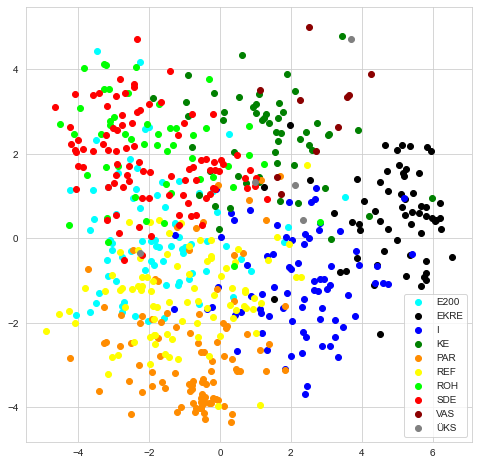

In [117]:
from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(X)

plt.rcParams["figure.figsize"] = (8,4)
plt.bar(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

plt.rcParams["figure.figsize"] = (8,8)
for party in partyToSubdf:
    idx = partyToSubdf[party].index
    plt.scatter(Xt[idx,0], Xt[idx,1], c=party_to_color[party], label=party)
plt.legend()
plt.show()

## TODO